In [1]:
import configparser
import math

import numpy as np
import pandas
from plotnine import *
import psycopg2
import sklearn.manifold
import umap

In [2]:
# Ensure TSNE always returns the same results
np.random.seed(42)

parser = configparser.ConfigParser()
parser.read('../database.ini')

db_password = parser['psql']['password']
epilepsy_id = 'DOID:1826'

supervised_predictions_df = pandas.read_csv('https://raw.githubusercontent.com/dhimmel/learn/b2460a1ecdec1078d673634688784f3eb5e3fc43/prediction/predictions/probabilities.tsv', sep='\t')

In [3]:
def construct_disease_query(disease_id):
    # If this query is used for different node types, it may be necessary to add an additional condition
    # that the matching node is of the correct type e.g. Disease
    query = f'''
            SELECT path_count, p_value, metapath_id, source_node.name AS source_name, 
                   target_node.name AS target_name, source_node.identifier AS source_identifier 
            FROM dj_hetmech_app_pathcount pc 
            JOIN dj_hetmech_app_node source_node 
               ON pc.source_id = source_node.id 
            JOIN dj_hetmech_app_node target_node 
               ON pc.target_id = target_node.id     
            WHERE target_node.identifier='{disease_id}' OR source_node.identifier='{disease_id}'
            ORDER BY pc.p_value
            '''
    return query

In [4]:
def get_disease_df(disease_id, db_password, supervised_predictions_df):
    query = construct_disease_query(disease_id)
    connection = psycopg2.connect(host = 'hetmech-db-dev.cobepk65dd7j.us-east-1.rds.amazonaws.com', 
                                  database = 'dj_hetmech', user = 'read_only_user', password = db_password)

    # Get the unsupervised compound information for a given disease
    metapaths = pandas.read_sql(query, connection)

    # If the source node is a disease instead of a compound, swap it with the target node
    reversed_indices = metapaths['source_identifier'] == disease_id
    metapaths['temp'] = metapaths['source_name']
    metapaths.loc[reversed_indices, 'source_name'] = metapaths['target_name']
    metapaths.loc[reversed_indices, 'target_name'] = metapaths['temp']

    metapaths = metapaths.drop(['temp', 'source_identifier'], axis=1)
    
    metapaths = metapaths.sort_values(by=['source_name', 'metapath_id'])
    # Ensure that you only have one copy of each (source_name, metapath_id) pair
    metapaths = metapaths.drop_duplicates(subset=['source_name', 'metapath_id'])
    # Remove any rows with NaN values
    metapaths = metapaths.dropna()
    min_p_value = metapaths[metapaths.p_value != 0].p_value.min()
    # Replace zero p-values to keep the log conversion from breaking
    metapaths.loc[metapaths.p_value == 0, 'p_value'] = min_p_value
    metapaths['neg_log_p_value'] = metapaths.p_value.apply(lambda x: -math.log10(x))

    max_column = metapaths.groupby('source_name')['neg_log_p_value'].max()
    mean_column = metapaths.groupby('source_name')['neg_log_p_value'].mean()

    neg_log_sum = metapaths.groupby('source_name').sum()
    neg_log_sum = neg_log_sum.sort_values(by='neg_log_p_value', ascending=False)

    neg_log_sum['max_neg_log'] = max_column
    neg_log_sum['mean_neg_log'] = mean_column
    neg_log_sum['max_percent_of_total'] = 100 * (neg_log_sum['max_neg_log'] / neg_log_sum['neg_log_p_value'])

    disease_predictions_df = supervised_predictions_df[supervised_predictions_df.disease_id == disease_id]
    # Remove predictions on drugs not in the other dataframe
    disease_predictions_df = disease_predictions_df[disease_predictions_df.compound_name.isin(neg_log_sum.index)]
    disease_predictions_df = disease_predictions_df.sort_values(by='disease_percentile', ascending=False)

    # Get the unsupervised compound ranking
    neg_log_sum = neg_log_sum.reset_index()
    neg_log_sum['unsupervised_rank'] = neg_log_sum.index

    # Sort neg_log_sum matching names in disease_predicitons_df 
    combined_df = neg_log_sum.merge(disease_predictions_df, how="left", right_on='compound_name', left_on='source_name')

    combined_df = combined_df.sort_values(by='disease_percentile', ascending=False).reset_index(drop=True)
    combined_df['supervised_rank'] = combined_df.index.copy()

    return metapaths, combined_df

In [5]:
metapath_df, sum_df = get_disease_df(epilepsy_id, db_password, supervised_predictions_df)
columns_to_drop = ['path_count',
                   'p_value',
                   'max_neg_log',
                   'mean_neg_log',
                   'max_percent_of_total',
                   'n_trials',
                   'status_trials',
                   'status_drugcentral',
                   'training_prediction',
                   'category',
                   'compound_name',
                   'disease_percentile',
                   'compound_percentile',
                   'prior_prob',
                   'prediction',
                   'disease_name'
                  ]
sum_df = sum_df.drop(columns_to_drop, axis=1)
sum_df.rename(columns = {'neg_log_p_value': 'compound_sum_neg_log_p_value'}, inplace=True)

sum_df['divergence'] = sum_df['supervised_rank'] - sum_df['unsupervised_rank']

sum_df.head()

,source_name,compound_sum_neg_log_p_value,unsupervised_rank,compound_id,disease_id,status,supervised_rank,divergence
0,Topiramate,43.735595,0,DB00273,DOID:1826,1,0,0
1,Ethotoin,34.047045,12,DB00754,DOID:1826,0,1,-11
2,Quazepam,24.477587,65,DB01589,DOID:1826,0,2,-63
3,Alprazolam,33.511351,15,DB00404,DOID:1826,0,3,-12
4,Primidone,33.931793,13,DB00794,DOID:1826,1,4,-9


In [6]:
combined_df = metapath_df.merge(sum_df)
combined_df = combined_df.sort_values(by='divergence')

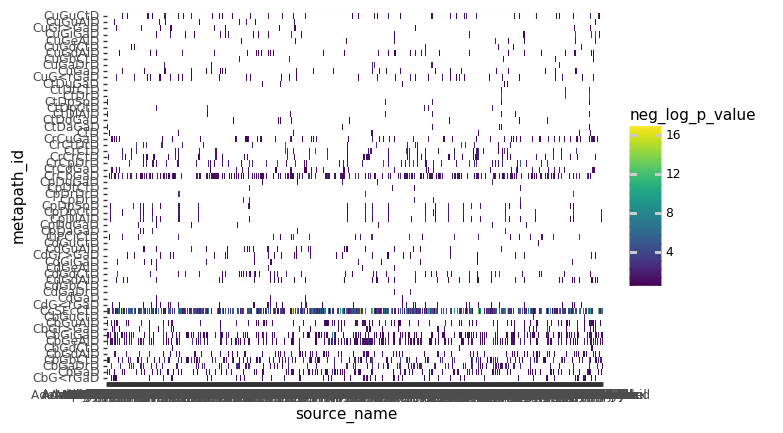

<ggplot: (-9223363285254230840)>

In [7]:
(ggplot(combined_df, aes('source_name', 'metapath_id', fill='neg_log_p_value'))
 + geom_tile()
)

In [8]:
pivot_df = combined_df.pivot('source_name', 'metapath_id', 'neg_log_p_value')
pivot_df = pivot_df.fillna(0)
# Drop compound treats disease edge to prevent information leaks
pivot_df = pivot_df.drop('CtD', axis=1)
pivot_df.head()

metapath_id,CbG<rGaD,CbGaD,CbGaDrD,CbGbCtD,CbGdAlD,CbGdCtD,CbGeAlD,CbGiGaD,CbGr>GaD,CbGuAlD,...,CuGaD,CuGaDrD,CuGbCtD,CuGdAlD,CuGdCtD,CuGeAlD,CuGiGaD,CuGr>GaD,CuGuAlD,CuGuCtD
source_name,,,,,,,,,,,,,,,,,,,,,
Abacavir,0.000000,1.968488,0.0,0.000000,2.186818,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abiraterone,0.000000,0.000000,0.0,0.000000,1.294707,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Acamprosate,0.000000,1.740126,0.0,3.934527,0.000000,0.0,3.199415,2.102324,0.0,1.823625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Acarbose,1.099501,0.000000,0.0,0.000000,1.101204,0.0,3.650422,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Acebutolol,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
embedded_data = sklearn.manifold.TSNE().fit_transform(pivot_df)

In [10]:
sum_df = sum_df.sort_values(by='source_name')

In [11]:
tsne_df = pandas.DataFrame({'axis1': embedded_data[:,0], 'axis2': embedded_data[:,1], 
                            'status': sum_df['status'], 'divergence': sum_df['divergence'],
                            'neg_log_p_value': sum_df['compound_sum_neg_log_p_value'], 
                            'source_name': pivot_df.index})
tsne_df = tsne_df.merge(pivot_df, left_on='source_name', right_index=True)
tsne_df.head()

,axis1,axis2,status,divergence,neg_log_p_value,source_name,CbG<rGaD,CbGaD,CbGaDrD,CbGbCtD,...,CuGaD,CuGaDrD,CuGbCtD,CuGdAlD,CuGdCtD,CuGeAlD,CuGiGaD,CuGr>GaD,CuGuAlD,CuGuCtD
760,8.556794,5.399414,0,-5,7.736997,Abacavir,0.000000,1.968488,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
463,-4.927469,1.732467,0,-753,3.644410,Abiraterone,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,-53.858093,-12.120009,0,50,26.122359,Acamprosate,0.000000,1.740126,0.0,3.934527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1175,37.713909,14.517929,0,528,8.953199,Acarbose,1.099501,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
939,-14.735936,-4.953999,0,-7,6.058565,Acebutolol,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


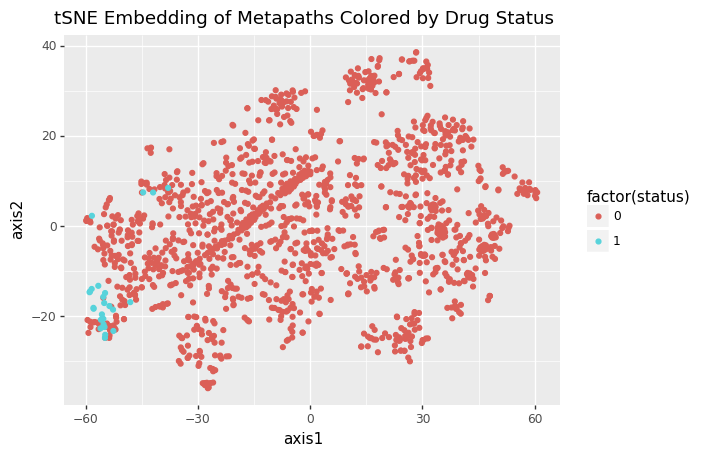

<ggplot: (-9223363285255699189)>

In [12]:
ggplot(tsne_df, aes('axis1', 'axis2', color='factor(status)')) + geom_point() + ggtitle('tSNE Embedding of Metapaths Colored by Drug Status')

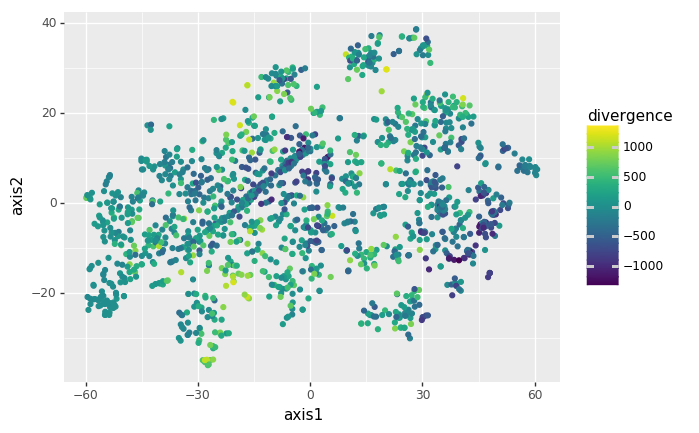

<ggplot: (8751598967430)>

In [13]:
ggplot(tsne_df, aes('axis1', 'axis2', color='divergence')) + geom_point() 

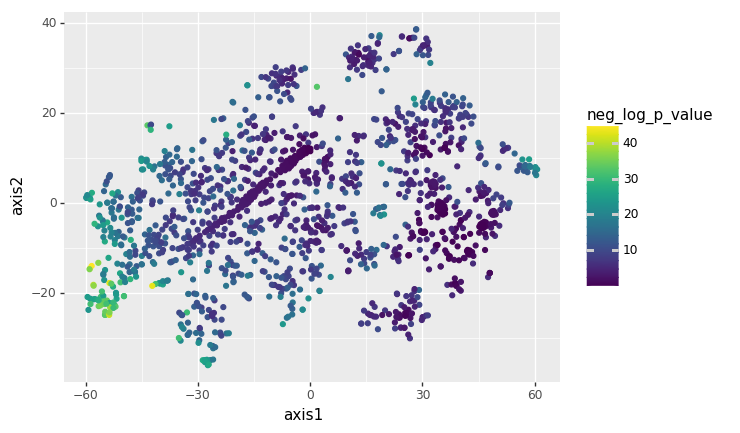

<ggplot: (8751593370793)>

In [14]:
ggplot(tsne_df, aes('axis1', 'axis2', color='neg_log_p_value')) + geom_point() 

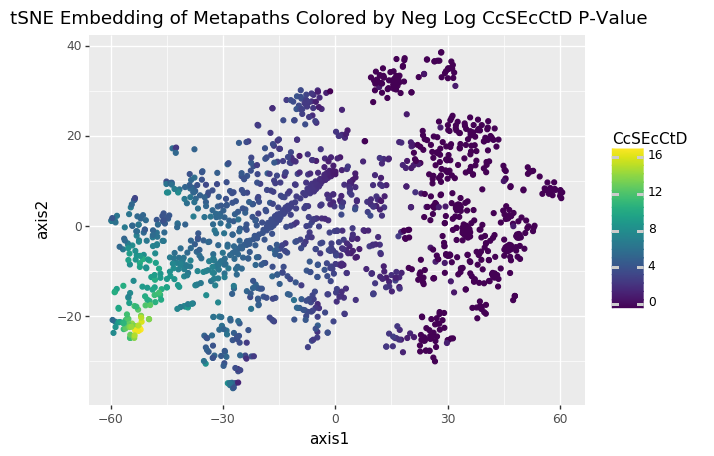

<ggplot: (8751593405844)>

In [15]:
ggplot(tsne_df, aes('axis1', 'axis2', color='CcSEcCtD')) + geom_point() + ggtitle('tSNE Embedding of Metapaths Colored by Neg Log CcSEcCtD P-Value')

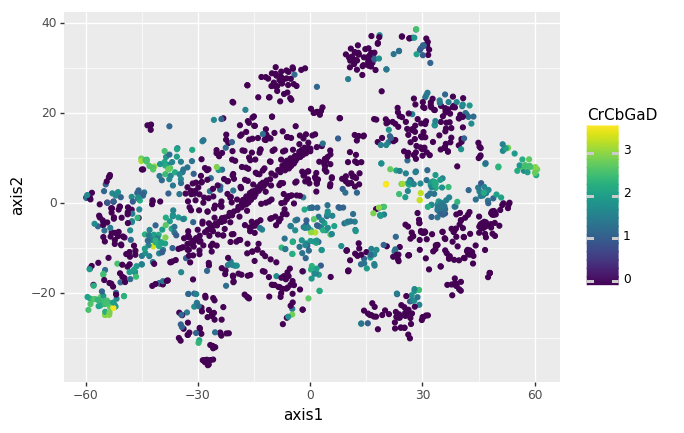

<ggplot: (8751591753827)>

In [16]:
ggplot(tsne_df, aes('axis1', 'axis2', color='CrCbGaD')) + geom_point() 

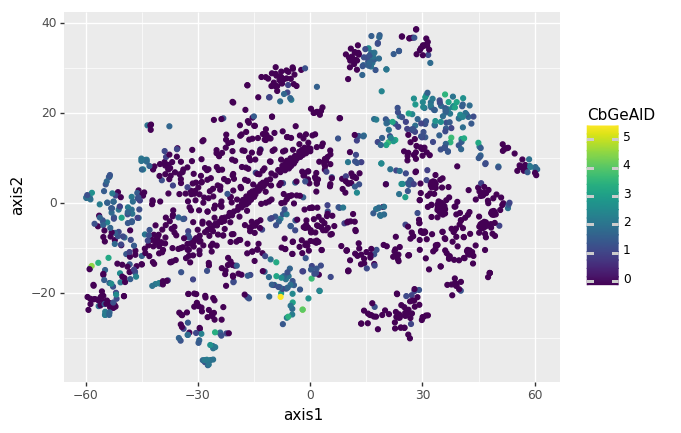

<ggplot: (-9223363285261317758)>

In [17]:
ggplot(tsne_df, aes('axis1', 'axis2', color='CbGeAlD')) + geom_point() 

In [18]:
embedded_data = umap.UMAP().fit_transform(pivot_df)

In [19]:
umap_df = pandas.DataFrame({'axis1': embedded_data[:,0], 'axis2': embedded_data[:,1], 
                            'status': sum_df['status'], 'divergence': sum_df['divergence'],
                            'neg_log_p_value': sum_df['compound_sum_neg_log_p_value'], 
                            'source_name': pivot_df.index})
umap_df = umap_df.merge(pivot_df, left_on='source_name', right_index=True)
umap_df.head()

,axis1,axis2,status,divergence,neg_log_p_value,source_name,CbG<rGaD,CbGaD,CbGaDrD,CbGbCtD,...,CuGaD,CuGaDrD,CuGbCtD,CuGdAlD,CuGdCtD,CuGeAlD,CuGiGaD,CuGr>GaD,CuGuAlD,CuGuCtD
760,-1.457687,5.556216,0,-5,7.736997,Abacavir,0.000000,1.968488,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
463,-1.330380,5.588799,0,-753,3.644410,Abiraterone,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,3.622695,5.168979,0,50,26.122359,Acamprosate,0.000000,1.740126,0.0,3.934527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1175,-4.230705,3.208268,0,528,8.953199,Acarbose,1.099501,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
939,0.088489,1.801574,0,-7,6.058565,Acebutolol,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


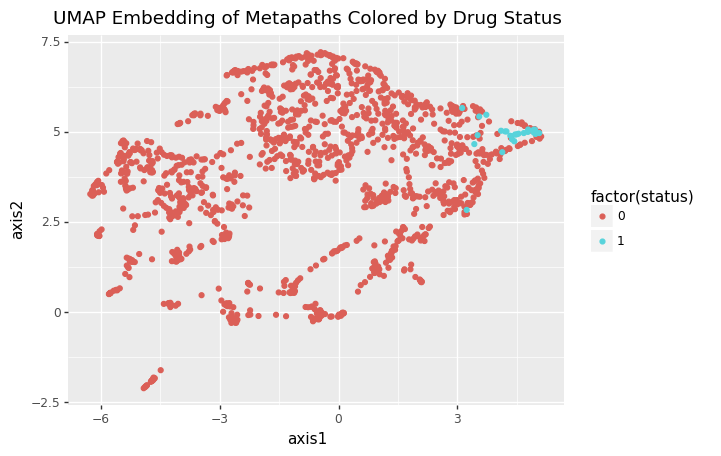

<ggplot: (8751600812499)>

In [20]:
ggplot(umap_df, aes('axis1', 'axis2', color='factor(status)')) + geom_point() + ggtitle('UMAP Embedding of Metapaths Colored by Drug Status')

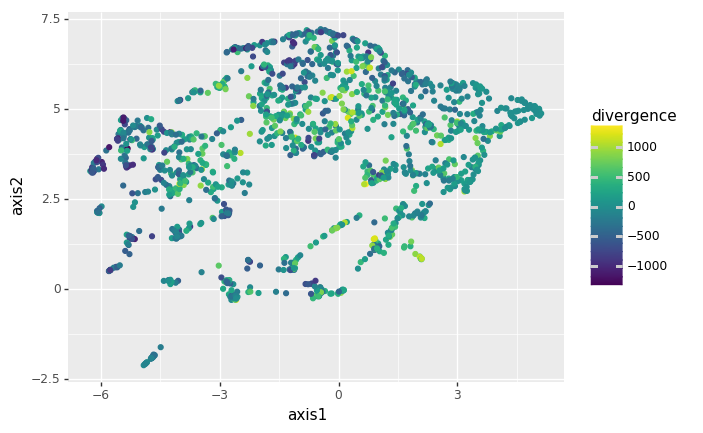

<ggplot: (-9223363285255720255)>

In [21]:
ggplot(umap_df, aes('axis1', 'axis2', color='divergence')) + geom_point() 

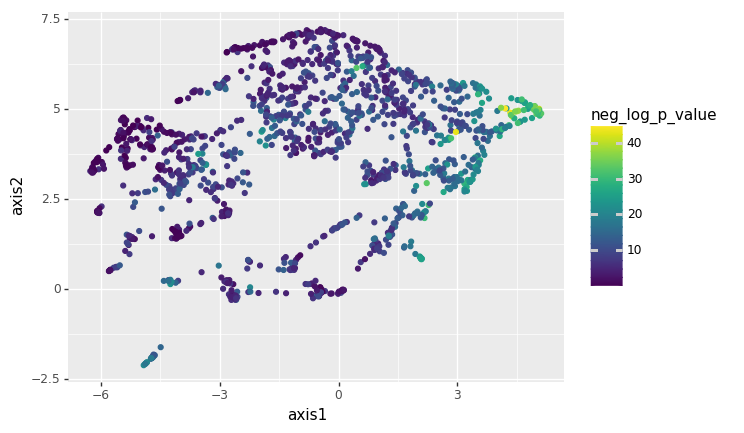

<ggplot: (8751593465138)>

In [22]:
ggplot(umap_df, aes('axis1', 'axis2', color='neg_log_p_value')) + geom_point() 

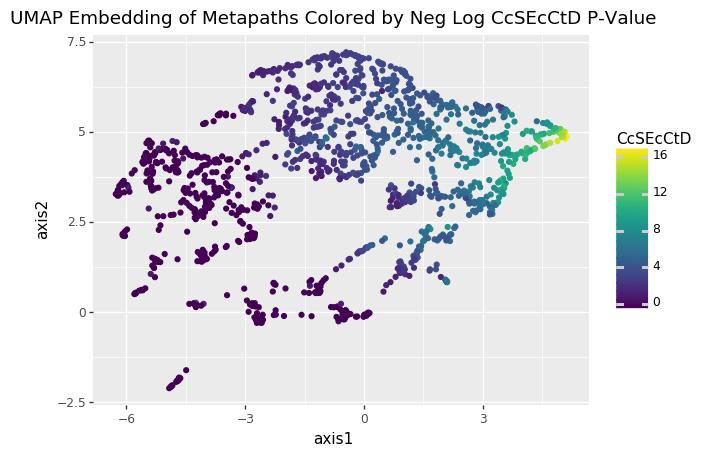

<ggplot: (8751598767592)>

In [23]:
ggplot(umap_df, aes('axis1', 'axis2', color='CcSEcCtD')) + geom_point() + ggtitle('UMAP Embedding of Metapaths Colored by Neg Log CcSEcCtD P-Value')

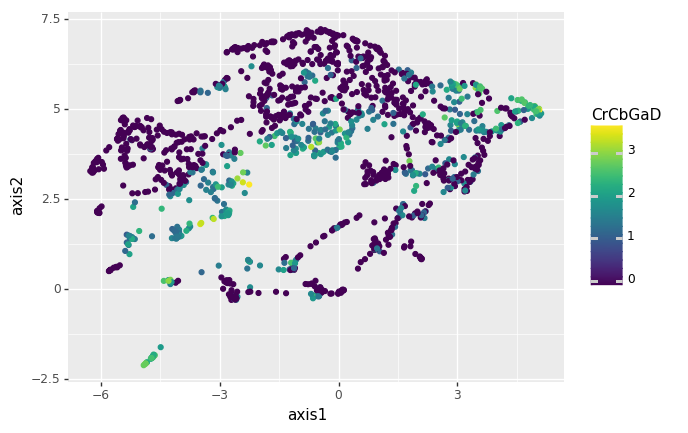

<ggplot: (8751591753806)>

In [24]:
ggplot(umap_df, aes('axis1', 'axis2', color='CrCbGaD')) + geom_point() 

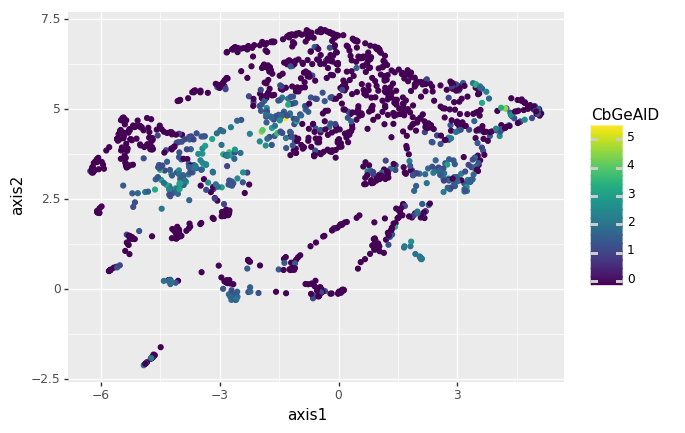

<ggplot: (8751591743103)>

In [25]:
ggplot(umap_df, aes('axis1', 'axis2', color='CbGeAlD')) + geom_point() 